In [37]:
# Uncomment this code if you are running on Google Colab
# ! pip install https://github.com/rcpaffenroth/generatedata
# ! pip install https://github.com/rcpaffenroth/iterativennsimple

<a href="https://colab.research.google.com/github/rcpaffenroth/iterativennsimple/blob/main/notebooks/3-rcp-iterated-2D-problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [38]:
# We use as few libraries as possible to make the code more portable, and to make it easier to understand.
# I.e., there are fewer libraries to learn.

import torch
import matplotlib.pyplot as plt
%matplotlib inline


In [39]:
# A few convenience functions for manipulating data and plotting

from generatedata.df_to_tensor import df_to_tensor
from generatedata.StartTargetData import StartTargetData
from generatedata.plot_2D_start_end import plot_2D_start_end
from generatedata.load_data import load_data

In [40]:
name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'

# Read the data
data_dict = load_data(name)

z_start = data_dict['start']
z_target = data_dict['target']


# Dynamical system

In [41]:
z_size = z_start.shape[1]
hidden_size = 15

iterations = 10
map = torch.nn.Sequential(torch.nn.Linear(z_size, hidden_size),
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, z_size))

In [42]:
# Make two pytorch tensor datasets from the start and target data
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)
    
train_data = StartTargetData(z_start_tensor, z_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [43]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [44]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = start
        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)
            loss += criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 3.5303549766540527
Epoch 100, Batch 9, Loss 0.015855062752962112
Epoch 200, Batch 9, Loss 0.001558264484629035
Epoch 300, Batch 9, Loss 0.00013834290439262986
Epoch 400, Batch 9, Loss 0.00010076510079670697


# Training data

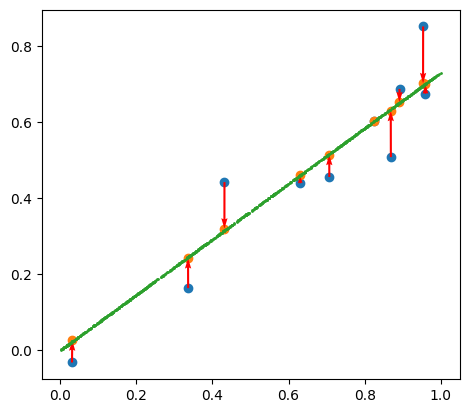

In [45]:
plot_iterations = 1
mapped_tensor = z_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_2D_start_end(z_start_tensor[:,0], z_start_tensor[:,1],
                  mapped_tensor[:,0], mapped_tensor[:,1], 
                  z_target_tensor[:,0], z_target_tensor[:,1])

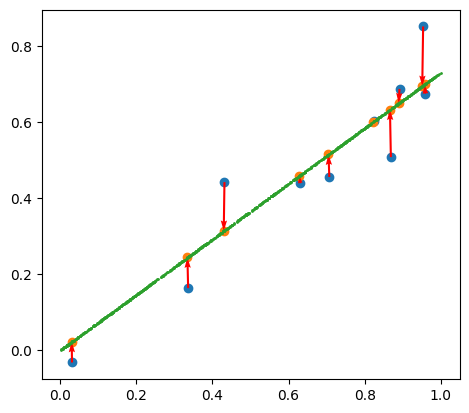

In [46]:
plot_iterations = iterations
mapped_tensor = z_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_2D_start_end(z_start_tensor[:,0], z_start_tensor[:,1],
                  mapped_tensor[:,0], mapped_tensor[:,1], 
                  z_target_tensor[:,0], z_target_tensor[:,1])

# Path

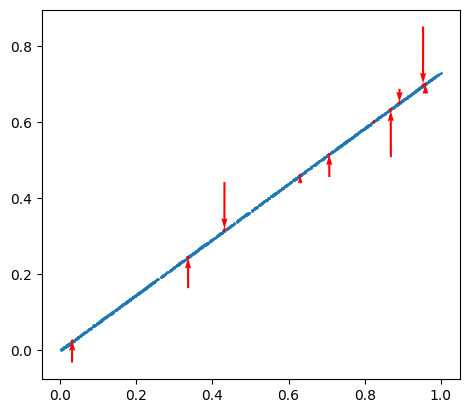

In [47]:
mapped_tensors = [z_start_tensor]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())

plot_points = 10

plt.figure()

plt.scatter(z_target_tensor[:,0], z_target_tensor[:,1], s=1)
for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        target = mapped_tensors[i]
        dx = target[:plot_points,0]-start[:plot_points,0]
        dy = target[:plot_points,1]-start[:plot_points,1]
        plt.quiver(start[:plot_points,0], start[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

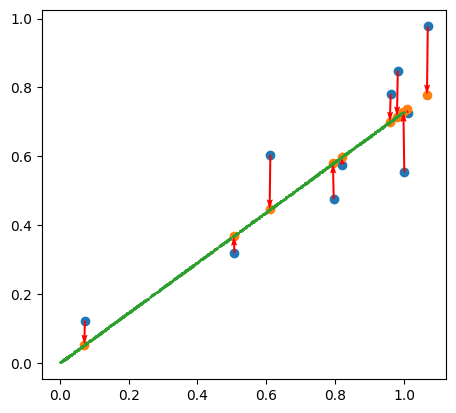

In [48]:
z_start_tensor_test = z_start_tensor+torch.rand_like(z_start_tensor)*0.2
mapped_tensor = z_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

plot_2D_start_end(z_start_tensor_test[:,0], z_start_tensor_test[:,1],
                  mapped_tensor[:,0], mapped_tensor[:,1], 
                  z_target_tensor[:,0], z_target_tensor[:,1])